# Import Statements

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl

# Parameters

In [2]:
source = 'combined'
sensor = 'pm25'
res_time = '3H'
filepath_root = '/scratch/ab9738/epod-nyu-delhi-pollution/'
spikes_file = filepath_root+'ankit/spikes.csv'
time_high_file = filepath_root+'ankit/time_high_3H.pkl'
time_low_file = filepath_root+'ankit/time_low_3H.pkl'
space_high_file = filepath_root+'ankit/space_high_3H.pkl'
space_low_file = filepath_root+'ankit/space_low_3H.pkl'

# Data Loading

In [3]:
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

# Load Hotspots

In [23]:
with open(time_low_file,'rb') as file:
    thsp_low = pkl.load(file)

In [24]:
with open(time_high_file,'rb') as file:
    thsp_high = pkl.load(file)

In [25]:
with open(space_high_file,'rb') as file:
    shsp_high = pkl.load(file)
with open(space_low_file,'rb') as file:
    shsp_low = pkl.load(file)

# Hotspot_Counts

In [26]:
# shsp_high is list of list. Every element list has timestamp, hotspot centre and other locations inside hotspot.
print(len(shsp_high))

shsp_high = np.array(shsp_high)

# Find the number of locations with highest number of spatial high hotspots.

shsp_high_counts = {}
for col in df.columns:
    shsp_high_counts[col] = 0

for i in range(len(shsp_high)):
    hsp = shsp_high[i]
    shsp_high_counts[hsp[1]] += 1
    for loc in hsp[2]:
#         if(df.loc[hsp[0]][hsp[1]]-df.loc[hsp[0]][loc]<50):
        shsp_high_counts[loc] += 1

df_counts_sph = pd.DataFrame.from_dict(shsp_high_counts,orient='Index',columns=['spatial_high'])

1969


/state/partition1/job-18677675/ipykernel_2812240/1545836603.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shsp_high = np.array(shsp_high)


In [27]:
# shsp_low is list of list. Every element list has timestamp, hotspot centre and other locations inside hotspot.
print(len(shsp_low))

shsp_low = np.array(shsp_low)

# Find the number of locations with highest number of spatial low hotspots.

shsp_low_counts = {}
for col in df.columns:
    shsp_low_counts[col] = 0

for i in range(len(shsp_low)):
    hsp = shsp_low[i]
    shsp_low_counts[hsp[1]] += 1
    for loc in hsp[2]:
#         if(df.loc[hsp[0]][loc]-df.loc[hsp[0]][hsp[1]]<50):
        shsp_low_counts[loc] += 1

df_counts_spl = pd.DataFrame.from_dict(shsp_low_counts,orient='Index',columns=['spatial_low'])

853


/state/partition1/job-18677675/ipykernel_2812240/81904359.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shsp_low = np.array(shsp_low)


In [28]:
num_hsps = 0
for col in df.columns:
    num_hsps += len(thsp_high[col])
print(num_hsps)

thsp_high_counts = {key:len(value) for key,value in thsp_high.items()}

df_counts_tmh = pd.DataFrame.from_dict(thsp_high_counts,orient='Index',columns=['temporal_high'])

8906


In [29]:
num_hsps = 0
for col in df.columns:
    num_hsps += len(thsp_low[col])
print(num_hsps)

thsp_low_counts = {key:len(value) for key,value in thsp_low.items()}

df_counts_tml = pd.DataFrame.from_dict(thsp_low_counts,orient='Index',columns=['temporal_low'])

df_counts = df_counts_sph.join(other=[df_counts_spl, df_counts_tmh, df_counts_tml])

2394


In [31]:
# df_counts.to_csv('govhotspot_counts_3H.csv')

## Results

In [32]:
df_counts.sort_values(by=['temporal_low'], ascending=False)[:10]

,spatial_high,spatial_low,temporal_high,temporal_low
4BE7,78,4,63,128
Rohini_DPCC,201,6,306,95
Wazirpur_DPCC,246,6,303,90
Jahangirpuri_DPCC,212,5,303,89
NehruNagar_DPCC,247,1,312,86
AshokVihar_DPCC,127,41,255,75
Mundaka_DPCC,208,11,283,73
AnandVihar_DPCC,183,3,253,73
DTU_CPCB,75,18,259,72
VivekVihar_DPCC,124,65,228,64


In [39]:
df_counts.sort_values(by=['spatial_low'], ascending=False)[:15]

,spatial_high,spatial_low,temporal_high,temporal_low
Pusa_IMD,17,101,137,19
LodhiRoad_IMD,13,96,116,26
NSIT_CPCB,36,94,151,26
IGIAirport_IMD,13,89,142,27
AyaNagar_IMD,38,80,126,18
MDCNS_DPCC,20,73,162,33
SriAurobindoMarg_DPCC,10,70,146,43
VivekVihar_DPCC,124,65,228,64
DwarkaSector8_DPCC,28,62,218,53
IHBAS_CPCB,87,57,176,34


In [42]:
locs.loc['E486']

UDID         4067187ca8d84d1584997699fc25e486
Latitude                            28.536617
Longitude                           77.372281
Address                           Kailas Home
Location                     Noida Sector 104
Type                                 Kaiterra
Name: E486, dtype: object

In [35]:
df_counts.sort_values(by=['temporal_high'], ascending=False)[:10]

,spatial_high,spatial_low,temporal_high,temporal_low
NehruNagar_DPCC,247,1,312,86
Rohini_DPCC,201,6,306,95
Wazirpur_DPCC,246,6,303,90
Jahangirpuri_DPCC,212,5,303,89
Mundaka_DPCC,208,11,283,73
DTU_CPCB,75,18,259,72
PunjabiBagh_DPCC,146,14,255,57
AshokVihar_DPCC,127,41,255,75
AnandVihar_DPCC,183,3,253,73
SoniaVihar_DPCC,66,36,246,63


In [37]:
df_counts.sort_values(by=['spatial_high'], ascending=False)[:10]

,spatial_high,spatial_low,temporal_high,temporal_low
NehruNagar_DPCC,247,1,312,86
Wazirpur_DPCC,246,6,303,90
Jahangirpuri_DPCC,212,5,303,89
Mundaka_DPCC,208,11,283,73
Rohini_DPCC,201,6,306,95
AnandVihar_DPCC,183,3,253,73
PunjabiBagh_DPCC,146,14,255,57
AshokVihar_DPCC,127,41,255,75
VivekVihar_DPCC,124,65,228,64
Shadipur_CPCB,107,55,245,46


# Common Occurance

In [18]:
co_thsh = 0
for col in df.columns:
    for i in range(len(thsp_high[col])):
        thsp = thsp_high[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[time][location]-df.loc[t][location]<50):
                shsp = shsp_high[shsp_high[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_thsh += 1
co_thsh

1442

In [19]:
co_tlsh = 0
for col in df.columns:
    for i in range(len(thsp_low[col])):
        thsp = thsp_low[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[t][location]-df.loc[time][location]<50):
                shsp = shsp_high[shsp_high[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_tlsh += 1
co_tlsh

108

In [20]:
co_thsl = 0
for col in df.columns:
    for i in range(len(thsp_high[col])):
        thsp = thsp_high[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[time][location]-df.loc[t][location]<50):
                shsp = shsp_low[shsp_low[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_thsl += 1
co_thsl

156

In [21]:
co_tlsl = 0
for col in df.columns:
    for i in range(len(thsp_low[col])):
        thsp = thsp_low[col][i]
        time = thsp[0]
        location = col
        time_range = thsp[2]
        for t in time_range:
            if(df.loc[t][location]-df.loc[time][location]<50):
                shsp = shsp_low[shsp_low[:,0]==t]
                for j in range(len(shsp)):
                    if(location==shsp[j][1]):
                        co_tlsl += 1
co_tlsl

69

# Inferences: Temporal Hotspots

In [103]:
time_interest_locs = set(df_counts.sort_values(by=['temporal_high'], ascending=False)[:10].index).intersection(\
                            set(df_counts.sort_values(by=['temporal_low'], ascending=False)[:10].index))

/state/partition1/job-18572487/ipykernel_2218890/3921831146.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  high_vals = np.array(high_hsps)[:,1]
/state/partition1/job-18572487/ipykernel_2218890/3921831146.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  low_vals = np.array(low_hsps)[:,1]


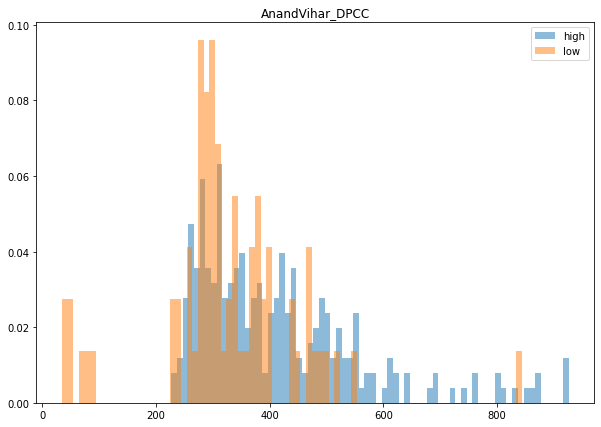

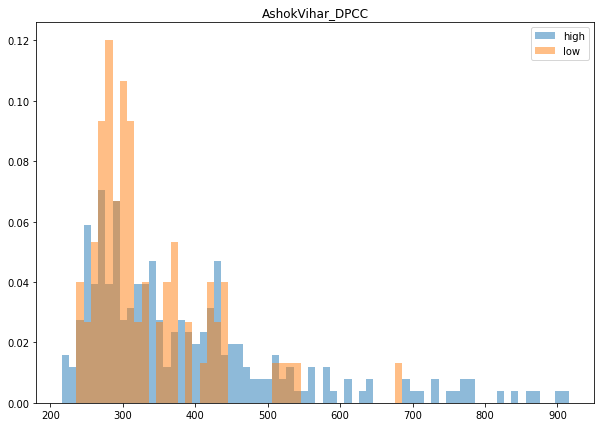

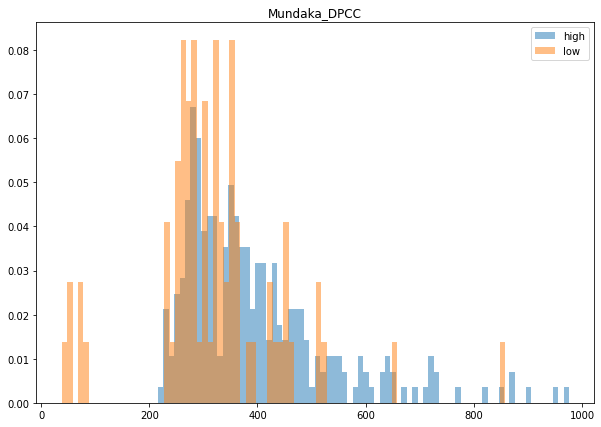

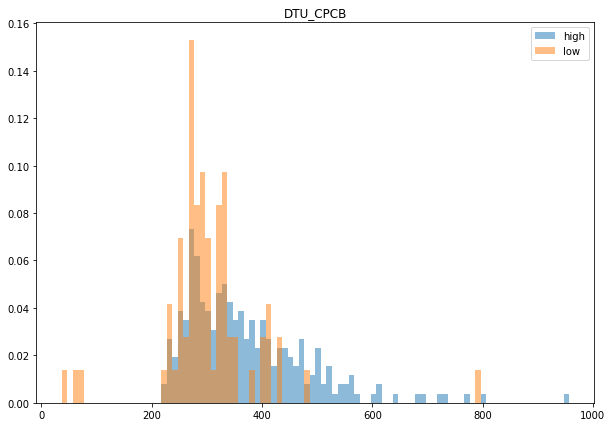

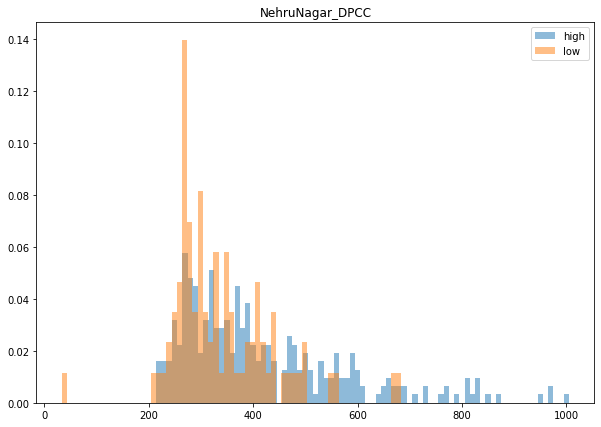

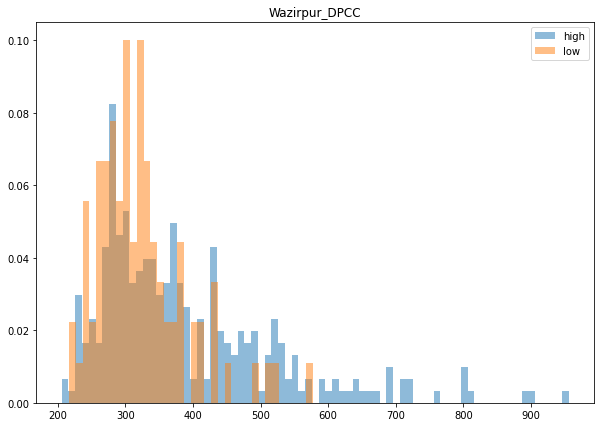

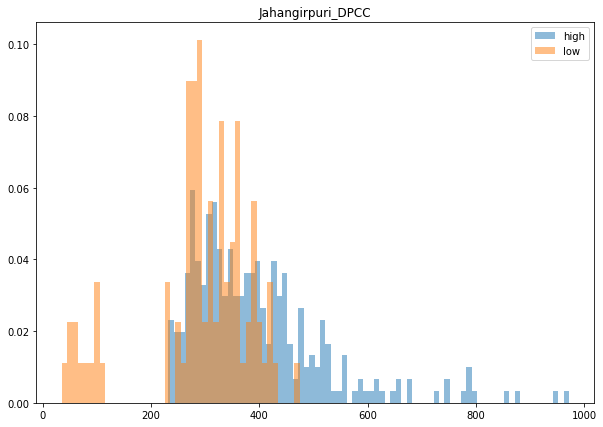

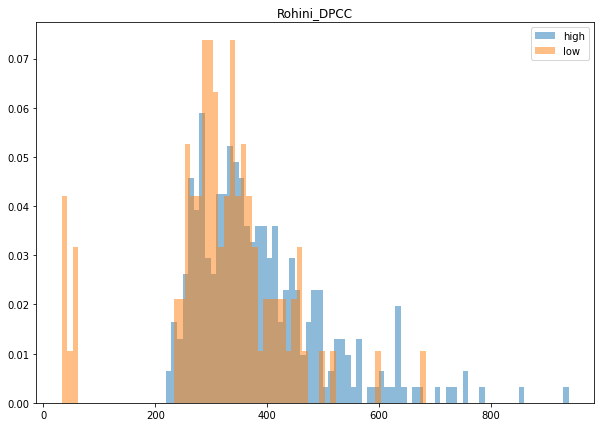

In [104]:
for location in list(time_interest_locs):
    high_hsps = thsp_high[location]
    low_hsps = thsp_low[location]
    high_vals = np.array(high_hsps)[:,1]
    low_vals = np.array(low_hsps)[:,1]
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(high_vals, weights=np.ones(len(high_vals))/len(high_vals),\
                bins=range(int(min(high_vals)),int(max(high_vals)) + 10, 10),cumulative=False,alpha=0.5,label='high')
    stats_low = plt.hist(low_vals, weights=np.ones(len(low_vals))/len(low_vals),\
                bins=range(int(min(low_vals)),int(max(low_vals)) + 10, 10),cumulative=False,alpha=0.5,label='low')
    plt.title(location)
    plt.legend()

In [105]:
high_pol_locs = set(df_counts.sort_values(by=['spatial_high'], ascending=False)[:10].index).intersection\
(time_interest_locs)

In [106]:
for location in high_pol_locs:
    print(location, df[location].mean(), df[location].std())

AnandVihar_DPCC 121.78385108712655 117.85420238154572
AshokVihar_DPCC 106.05372376154493 109.78523768906804
Mundaka_DPCC 116.51601454765873 118.42891255711518
NehruNagar_DPCC 110.83204182718768 121.35814053212074
Wazirpur_DPCC 118.78676101505856 116.42626335045303
Jahangirpuri_DPCC 119.56125104369606 112.76653861575384
Rohini_DPCC 116.55189862783533 112.60002521392244


In [107]:
print(df['Jahangirpuri_DPCC'].mean(), df['Jahangirpuri_DPCC'].std())

119.56125104369606 112.76653861575384


/state/partition1/job-18572487/ipykernel_2218890/433554290.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  high_vals = np.array(high_hsps)[:,1]
/state/partition1/job-18572487/ipykernel_2218890/433554290.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  low_vals = np.array(low_hsps)[:,1]


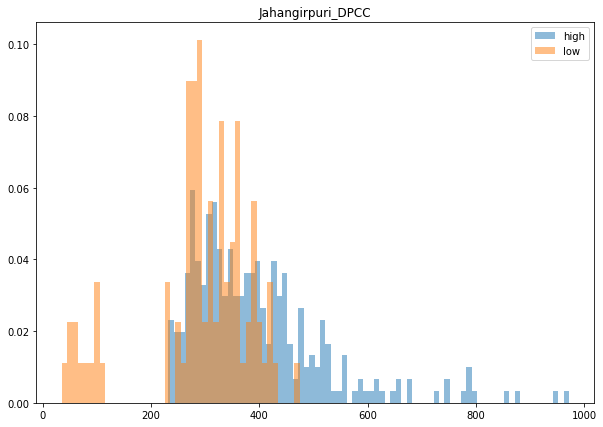

In [108]:
location = 'Jahangirpuri_DPCC'
high_hsps = thsp_high[location]
low_hsps = thsp_low[location]
high_vals = np.array(high_hsps)[:,1]
low_vals = np.array(low_hsps)[:,1]
fig, ax = plt.subplots(figsize=(10,7))
stats_high = plt.hist(high_vals, weights=np.ones(len(high_vals))/len(high_vals),\
            bins=range(int(min(high_vals)),int(max(high_vals)) + 10, 10),cumulative=False,alpha=0.5,label='high')
stats_low = plt.hist(low_vals, weights=np.ones(len(low_vals))/len(low_vals),\
            bins=range(int(min(low_vals)),int(max(low_vals)) + 10, 10),cumulative=False,alpha=0.5,label='low')
plt.title(location)
plt.legend()

In [109]:
roi_vals = (stats_low[1]+5)[stats_low[1]<200]
(stats_low[0][:len(roi_vals)]).sum()

0.1348314606741573

# Compare with only Government Data Hotspots

In [76]:
df_gov = pd.read_csv('govhotspot_counts_3H.csv',index_col=0)
df_com = pd.read_csv('hotspot_counts_3H.csv',index_col=0)
df_gov.columns = df_gov.columns + '_gov'
df_com.columns = df_com.columns + '_com'

In [82]:
df_hotspots = df_com.join([df_gov])

In [83]:
df_hotspots.sort_values(by=['spatial_low_gov'], ascending=False)[:10]

,spatial_high_com,spatial_low_com,temporal_high_com,temporal_low_com,spatial_high_gov,spatial_low_gov,temporal_high_gov,temporal_low_gov
Pusa_IMD,15,104,137,19,12.0,124.0,137.0,19.0
LodhiRoad_IMD,14,81,116,26,12.0,105.0,116.0,26.0
NSIT_CPCB,40,86,151,26,29.0,88.0,151.0,26.0
MDCNS_DPCC,18,65,162,33,12.0,88.0,162.0,33.0
IGIAirport_IMD,12,98,142,27,11.0,87.0,142.0,27.0
Pusa_DPCC,19,52,185,40,10.0,75.0,185.0,40.0
VivekVihar_DPCC,138,62,228,64,126.0,63.0,228.0,64.0
DwarkaSector8_DPCC,30,51,218,53,21.0,62.0,218.0,53.0
IHBAS_CPCB,85,49,176,34,65.0,48.0,176.0,34.0
SriAurobindoMarg_DPCC,13,36,146,43,11.0,46.0,146.0,43.0


In [84]:
df_hotspots.sort_values(by=['spatial_low_com'], ascending=False)[:10]

,spatial_high_com,spatial_low_com,temporal_high_com,temporal_low_com,spatial_high_gov,spatial_low_gov,temporal_high_gov,temporal_low_gov
Pusa_IMD,15,104,137,19,12.0,124.0,137.0,19.0
IGIAirport_IMD,12,98,142,27,11.0,87.0,142.0,27.0
NSIT_CPCB,40,86,151,26,29.0,88.0,151.0,26.0
20CA,10,82,106,15,NaN,NaN,NaN,NaN
CBC7,2,81,120,25,NaN,NaN,NaN,NaN
LodhiRoad_IMD,14,81,116,26,12.0,105.0,116.0,26.0
AyaNagar_IMD,35,74,126,18,0.0,0.0,126.0,18.0
MDCNS_DPCC,18,65,162,33,12.0,88.0,162.0,33.0
VivekVihar_DPCC,138,62,228,64,126.0,63.0,228.0,64.0
Pusa_DPCC,19,52,185,40,10.0,75.0,185.0,40.0


In [113]:
# df_hotspots

# Inferences: Spatial Hotspots

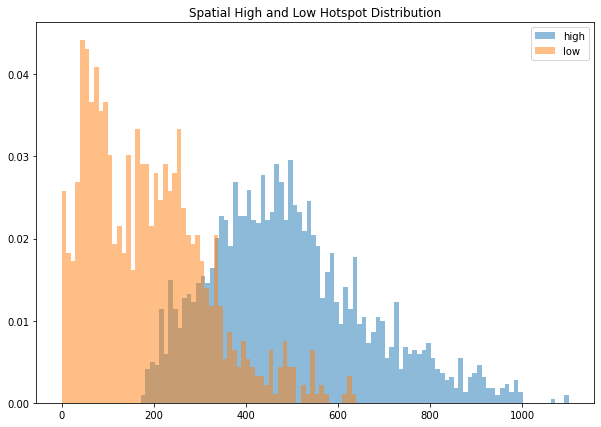

In [116]:
val_high = []
val_low = []
for i in range(len(shsp_high)):
    hsp_loc = shsp_high[i][1]
    hsp_time = shsp_high[i][0]
    val = df.loc[hsp_time][hsp_loc]
    val_high.append(val)
for i in range(len(shsp_low)):
    hsp_loc = shsp_low[i][1]
    hsp_time = shsp_low[i][0]
    val = df.loc[hsp_time][hsp_loc]
    val_low.append(val)
    
high_vals = np.array(val_high)
low_vals = np.array(val_low)
    
fig, ax = plt.subplots(figsize=(10,7))
stats_high = plt.hist(high_vals, weights=np.ones(len(high_vals))/len(high_vals),\
            bins=range(int(min(high_vals)),int(max(high_vals)) + 10, 10),cumulative=False,alpha=0.5,label='high')
stats_low = plt.hist(low_vals, weights=np.ones(len(low_vals))/len(low_vals),\
            bins=range(int(min(low_vals)),int(max(low_vals)) + 10, 10),cumulative=False,alpha=0.5,label='low')
plt.title('Spatial High and Low Hotspot Distribution')
plt.legend()

In [118]:
roi_vals = (stats_low[1]+5)[stats_low[1]<200]
(stats_low[0][:len(roi_vals)]).sum()

0.5737351991388617

In [119]:
low_pol_locs = list(df_hotspots.sort_values(by=['spatial_low_com'], ascending=False)[:10].index)

In [121]:
for location in low_pol_locs:
    print(location, df[location].mean(), df[location].std())

Pusa_IMD 76.73656137724551 76.880506230685
IGIAirport_IMD 79.72844107013738 77.93943823599132
NSIT_CPCB 97.19454933847851 75.45529246374501
20CA 91.38495092027787 91.35296978650194
CBC7 95.16627540974565 85.99461803311101
LodhiRoad_IMD 77.04841897810218 71.64463571079081
AyaNagar_IMD 76.38852652825837 71.65565244237025
MDCNS_DPCC 86.4155242825607 80.24701518578178
VivekVihar_DPCC 101.47838988968022 103.59810767448408
Pusa_DPCC 91.6592432264092 91.68556915868349


In [124]:
for location in low_pol_locs:
    roi_hsp = shsp_low[shsp_low[:,1]==location]
    vals = df.loc[roi_hsp[:,0]][location]
    print(location, vals.mean(), vals.std())

Pusa_IMD 157.8022950819672 97.64583878134017
IGIAirport_IMD 226.13444444444443 95.2190403961742
NSIT_CPCB 193.885 119.33549612631728
20CA 192.89023727642268 117.6529004804177
CBC7 201.20760192966074 120.56566342287974
LodhiRoad_IMD 204.17603773584906 96.24148302656394
AyaNagar_IMD 182.19927536231884 98.02875622997871
MDCNS_DPCC 203.05423076923077 122.59925713227065
VivekVihar_DPCC 84.46435483870968 81.60115720854493
Pusa_DPCC 243.86133333333333 69.4056884110339


In [125]:
for location in high_pol_locs:
    roi_hsp = shsp_high[shsp_high[:,1]==location]
    vals = df.loc[roi_hsp[:,0]][location]
    print(location, vals.mean(), vals.std())

AnandVihar_DPCC 536.8469718309859 164.42150470207858
AshokVihar_DPCC 606.685 149.95205667615383
Mundaka_DPCC 509.61614906832307 155.85636853390895
NehruNagar_DPCC 507.20328638497654 163.45234593021945
Wazirpur_DPCC 508.0963095238095 145.4052003886769
Jahangirpuri_DPCC 491.5517391304348 152.61854557172205
Rohini_DPCC 500.887476635514 134.20752359961932


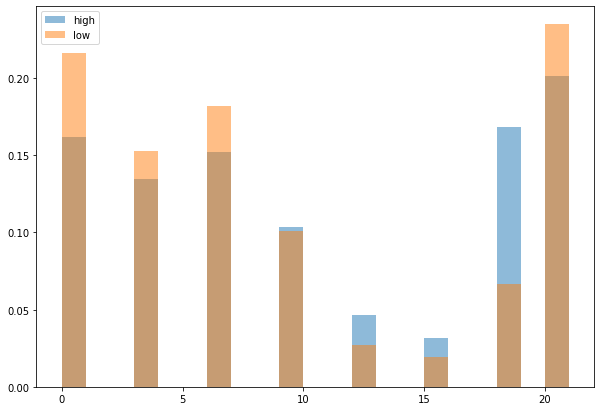

In [130]:
time_high = []
for i in range(len(shsp_high)):
    time_high.append(shsp_high[i][0].time().hour)
time_low = []
for i in range(len(shsp_low)):
    time_low.append(shsp_low[i][0].time().hour)
fig, ax = plt.subplots(figsize=(10,7))
stats_high = plt.hist(time_high, weights=np.ones(len(time_high))/len(time_high), \
                 bins=range(int(min(time_high)),int(max(time_high)) + 1, 1), cumulative=False,alpha=0.5,label='high')
stats_low = plt.hist(time_low, weights=np.ones(len(time_low))/len(time_low), \
                 bins=range(int(min(time_low)),int(max(time_low)) + 1, 1), cumulative=False,alpha=0.5,label='low')
plt.legend()

# Duration for Temporal Hotspots

/state/partition1/job-18572487/ipykernel_2218890/1640478924.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  high_time_wins = np.array(high_hsps)[:,2]
/state/partition1/job-18572487/ipykernel_2218890/1640478924.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  low_time_wins = np.array(low_hsps)[:,2]


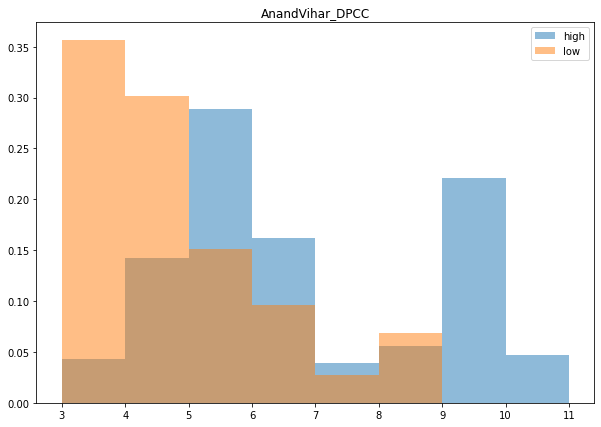

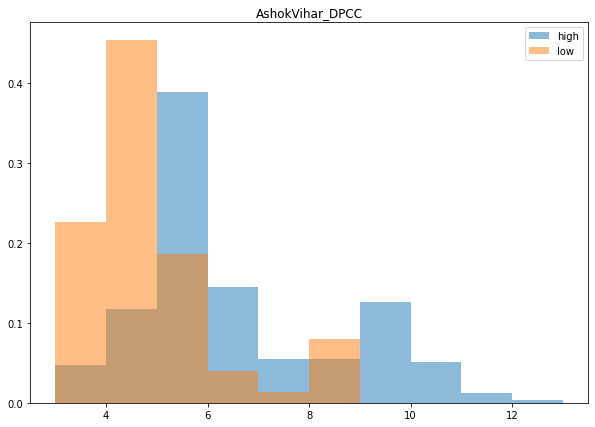

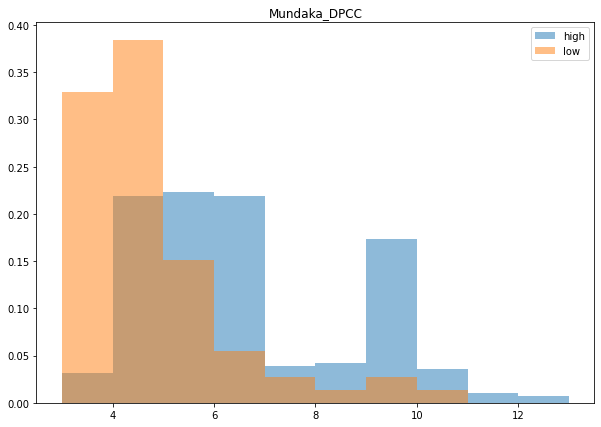

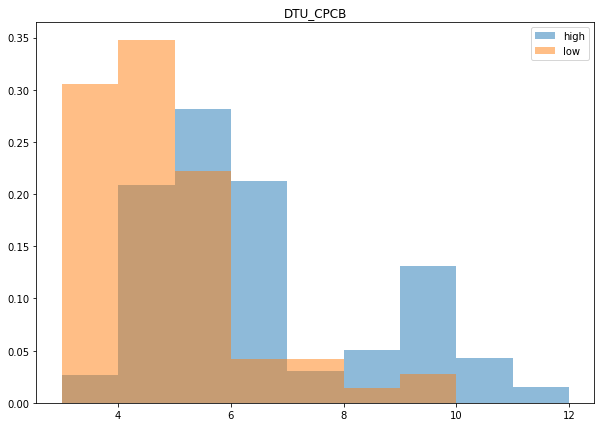

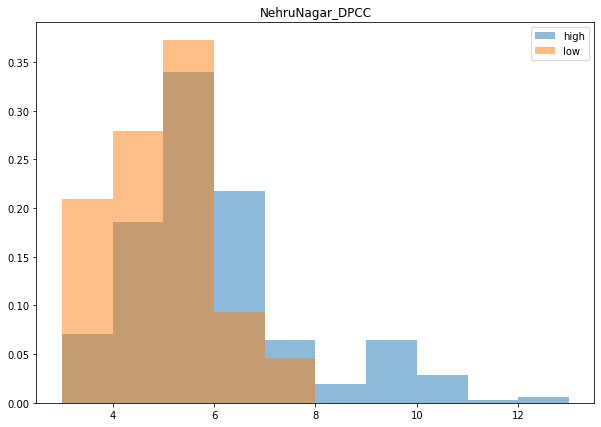

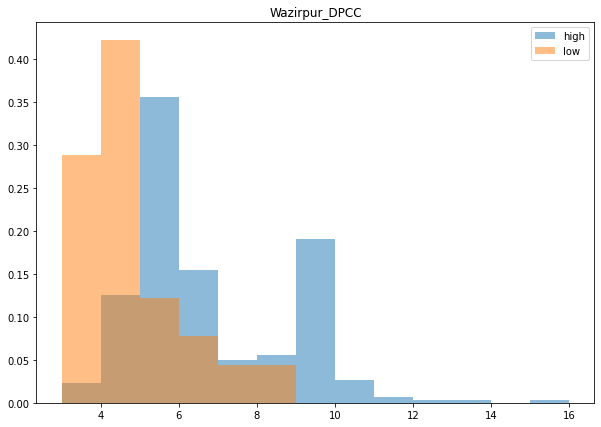

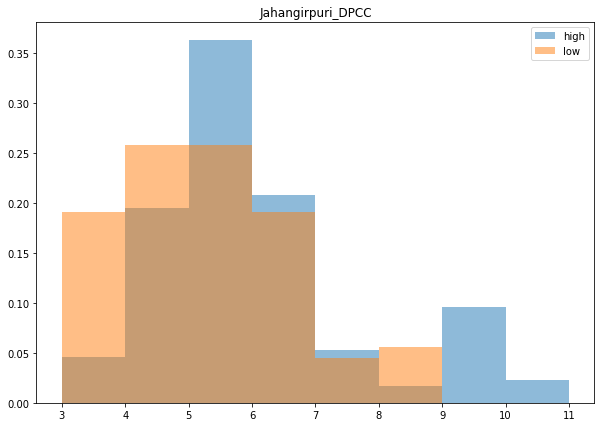

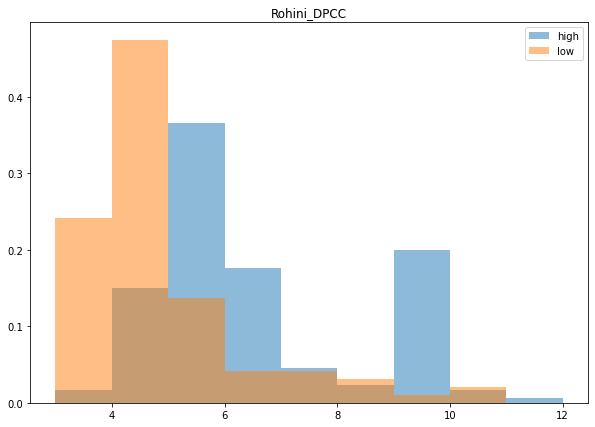

In [128]:
for location in list(time_interest_locs):
    high_hsps = thsp_high[location]
    low_hsps = thsp_low[location]
    high_time_wins = np.array(high_hsps)[:,2]
    f = lambda x: len(x)
    high_ints = np.array([f(xi) for xi in high_time_wins])
    low_time_wins = np.array(low_hsps)[:,2]
    low_ints = np.array([f(xi) for xi in low_time_wins])
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(high_ints, weights=np.ones(len(high_ints))/len(high_ints),\
                bins=range(int(min(high_ints)),int(max(high_ints)) + 1, 1),cumulative=False,alpha=0.5,label='high')
    stats_low = plt.hist(low_ints, weights=np.ones(len(low_ints))/len(low_ints),\
                bins=range(int(min(low_ints)),int(max(low_ints)) + 1, 1),cumulative=False,alpha=0.5,label='low')
    plt.title(location)
    plt.legend()

# Radius of Spatial Hotspots

In [132]:
# nn_dict = {}
# for col in df.columns:
#     dist_df = distances.loc[col].sort_values().dropna()
#     nn_dict[col] = dist_df

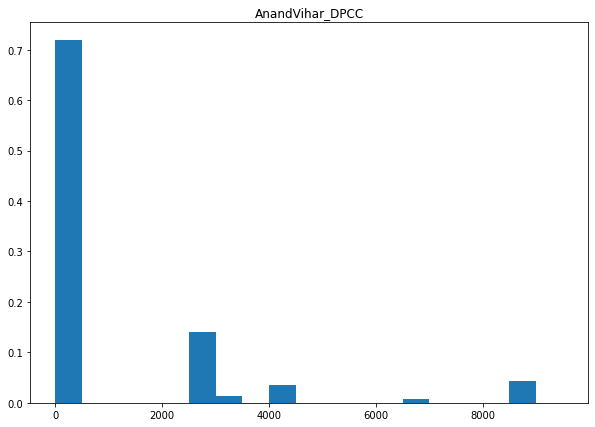

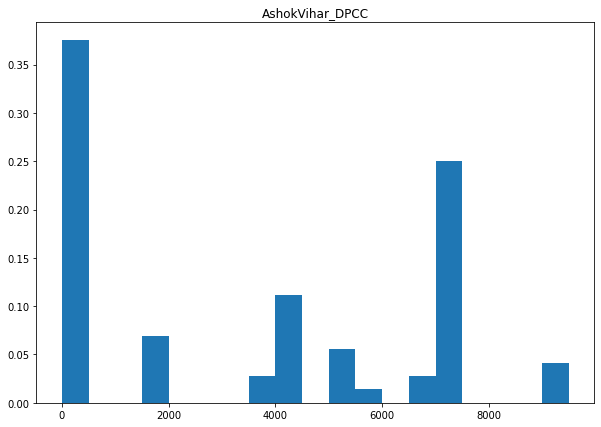

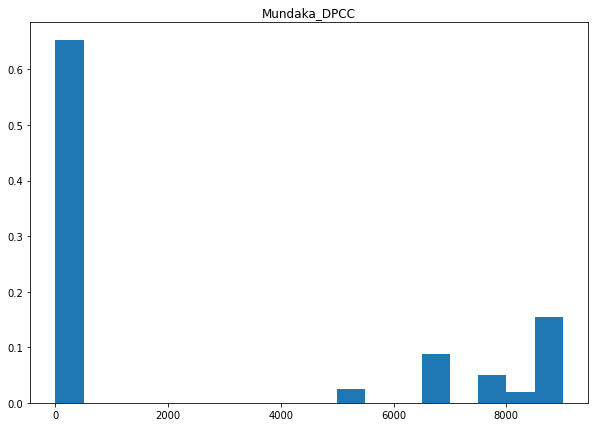

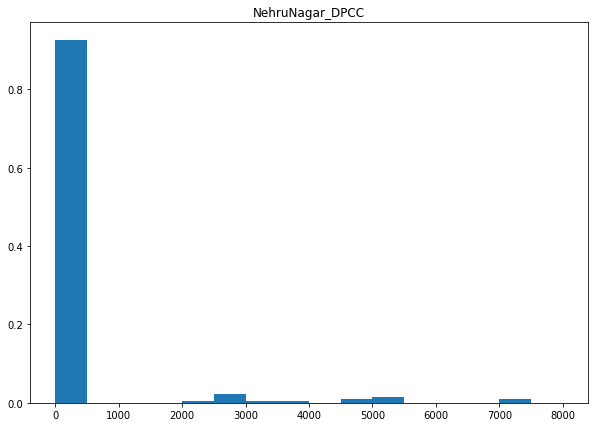

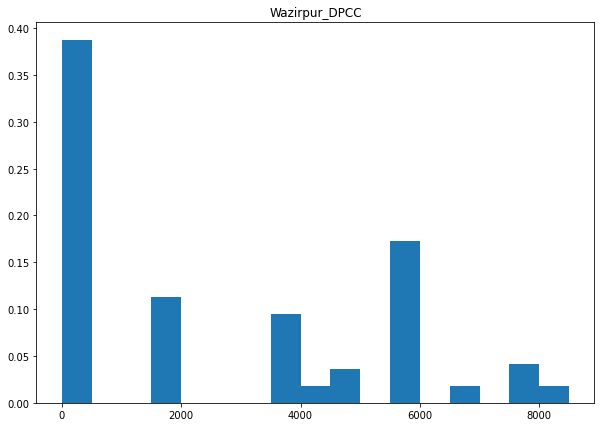

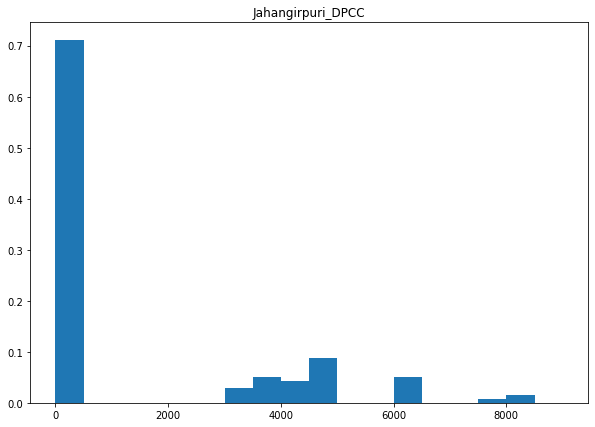

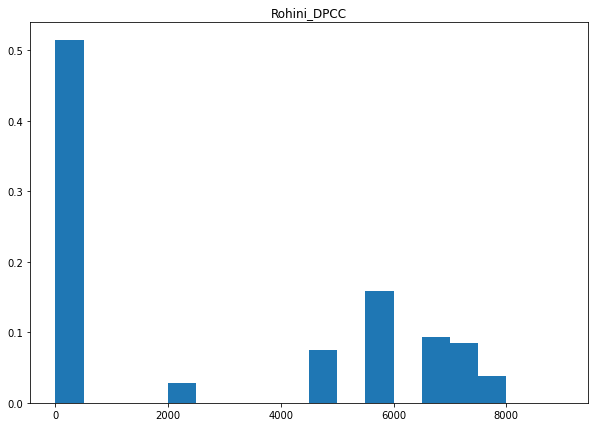

In [136]:
for location in high_pol_locs:
    roi_hsp = shsp_high[shsp_high[:,1]==location]
    dist = []
    for hsp in roi_hsp:
        time = hsp[0]
        cen = hsp[1]
        d = 0
        for stn in hsp[2]:
            if(df.loc[time][cen]-df.loc[time][stn]<50):
                d = max(d,distances.loc[cen][stn])
        dist.append(d)
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(dist, weights=np.ones(len(dist))/len(dist),\
                bins=range(int(min(dist)),int(max(dist)) + 1, 500),cumulative=False,alpha=1,label='high')
    plt.title(location)

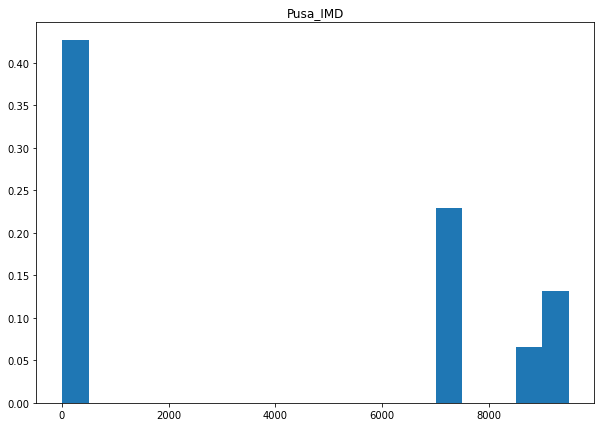

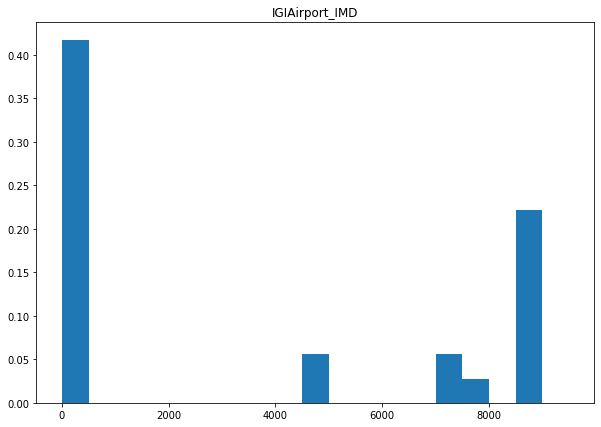

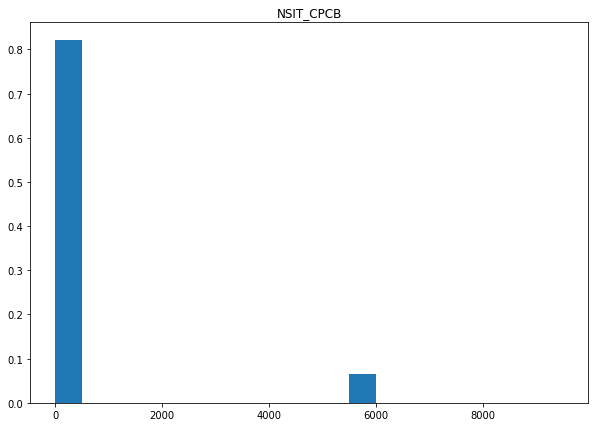

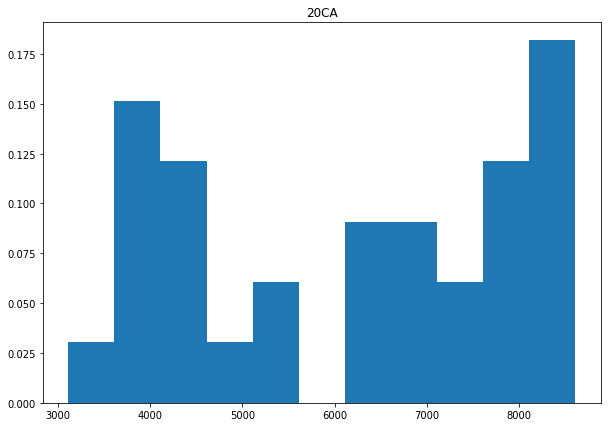

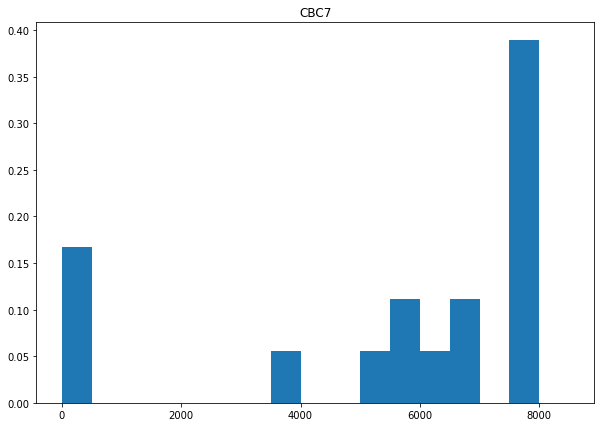

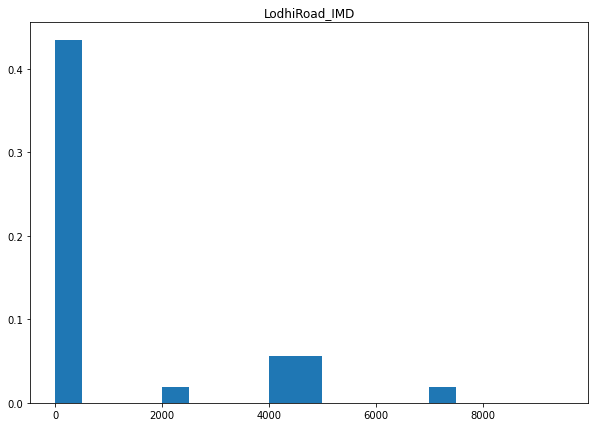

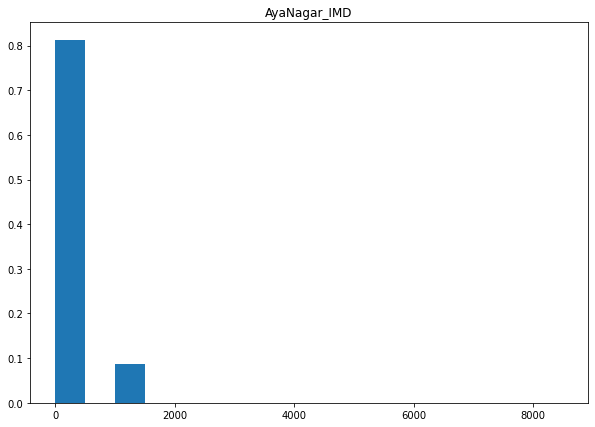

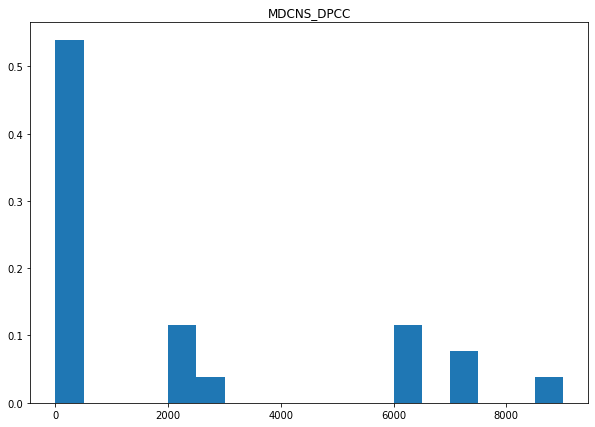

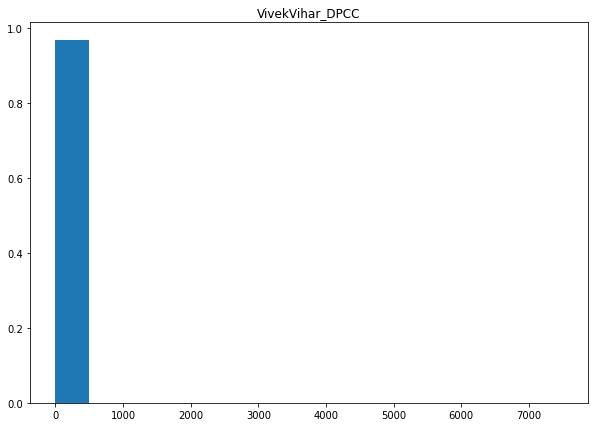

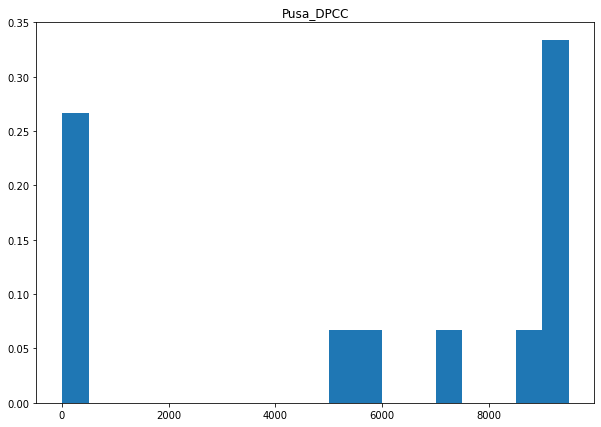

In [137]:
for location in low_pol_locs:
    roi_hsp = shsp_low[shsp_low[:,1]==location]
    dist = []
    for hsp in roi_hsp:
        time = hsp[0]
        cen = hsp[1]
        d = 0
        for stn in hsp[2]:
            if(df.loc[time][stn]-df.loc[time][cen]<50):
                d = max(d,distances.loc[cen][stn])
        dist.append(d)
    fig, ax = plt.subplots(figsize=(10,7))
    stats_high = plt.hist(dist, weights=np.ones(len(dist))/len(dist),\
                bins=range(int(min(dist)),int(max(dist)) + 1, 500),cumulative=False,alpha=1,label='high')
    plt.title(location)

In [25]:
df_counts

,spatial_high,spatial_low,temporal_high,temporal_low
113E,44,17,138,45
1FD7,1,41,32,9
20CA,10,82,106,15
2E9C,10,7,12,3
3ACF,0,0,1,0
498F,0,0,0,0
4BE7,70,9,63,128
56C3,2,14,93,25
5D7A,0,2,2,0
603A,17,20,72,8
